# Aula 2 - Parte Prática - Policy Gradients 

## Introdução

Nesse segundo notebook vamos aprender ...

### Objetivos:

- Entender a abordagem de otimização de políticas como busca no espaço de parâmetros da política
- Implementar um primeiro agente baseado no algoritmo REINFORCE
- Familiarizar-se com a API básica de construção de modelos (i.e., redes neurais) em Keras
- Familiarizar-se com métodos de Deep Learning usando TensorFlow 2.X

### Imports

> **Atenção:** não se esqueça de executar todos os `imports` necessários antes prosseguir com o tutorial.

In [1]:
import gym
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from utils.agent import RLAgent
from utils.memory import OnPolicyReplay
from utils.runner import run
from utils.viz import plot_returns

# sanity check
assert tf.__version__ == '2.1.0'
assert tf.executing_eagerly()

tf.get_logger().setLevel('ERROR') # ignore TensorFlow warnings

Loading BokehJS ...

## 1. Implementando políticas estocásticas em tf.Keras 

In [2]:
tfd = tfp.distributions

### 1.1 Caso discreto

In [3]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, input_shape=(5,), activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(3),
    tfp.layers.DistributionLambda(lambda t: tfd.Categorical(logits=t))
])

In [4]:
inputs = tf.random.normal(shape=(10, 5))
print(inputs)

tf.Tensor(
[[-0.7444643  -1.0475312  -0.29056537  0.8828211   1.3506389 ]
 [ 1.4069706   0.9374401  -0.86745805  1.8125968  -0.76917917]
 [-1.130297   -0.23253419 -0.0187826  -0.93867695 -0.63750505]
 [ 0.69026935 -0.5617041  -1.1220707   0.42468828  0.46068782]
 [-0.9094045   0.07095436  1.3718253  -0.5773402   0.16723084]
 [ 0.8218978   1.207092   -0.293446   -0.25948665 -0.892788  ]
 [ 0.25796482  1.4070626  -0.16256706  1.3955886   0.21690038]
 [ 0.23921257  0.6234027  -2.5287538   0.7009856   1.0163685 ]
 [-1.3217709   0.24936178  0.43768683 -0.5972467   0.38922352]
 [-0.8898578  -0.16596594  0.30077872 -0.01209459  1.0541759 ]], shape=(10, 5), dtype=float32)


In [5]:
dist = model(inputs)
print(dist)

tfp.distributions.Categorical("sequential_distribution_lambda_Categorical", batch_shape=[10], event_shape=[], dtype=int32)


In [6]:
sample = dist.sample()
print(sample)

tf.Tensor([0 0 2 0 0 1 0 0 2 1], shape=(10,), dtype=int32)


In [7]:
sample_log_prob = dist.log_prob(sample)
print(sample_log_prob)

tf.Tensor(
[-1.0762451  -0.83198786 -1.0190479  -1.0107522  -0.85665494 -1.1138203
 -1.0206085  -0.76191837 -1.2078855  -1.1761627 ], shape=(10,), dtype=float32)


In [8]:
def build_discrete_policy(obs_space, action_space, hidden_layers, activation="relu"):
    Input = tf.keras.Input
    Dense = tf.keras.layers.Dense
    DistributionLambda = tfp.layers.DistributionLambda
    Categorical = tfd.Categorical
    
    policy_net_layers = []

    policy_net_layers.append(Input(shape=obs_space.shape, name="State"))

    for i, units in enumerate(hidden_layers):
        policy_net_layers.append(Dense(units=units, activation=activation, name=f"Hidden{i+1}"))
    
    policy_net_layers.append(Dense(units=action_space.n, name="Logits"))
    policy_net_layers.append(DistributionLambda(lambda t: Categorical(logits=t), name="Action_Distribution_Categorical"))
                                     
    return tf.keras.Sequential(policy_net_layers)


In [9]:
env = gym.make("MountainCar-v0")

hidden_layers = [64, 64]
activation = "relu"

policy = build_discrete_policy(env.observation_space, env.action_space, hidden_layers, activation)

obs = env.observation_space.sample()

action_dist = policy(obs[None,:])
print(action_dist)
print(action_dist.sample())

action = action_dist.sample().numpy()
assert action[0] in env.action_space

tfp.distributions.Categorical("sequential_1_Action_Distribution_Categorical_Categorical", batch_shape=[1], event_shape=[], dtype=int32)
tf.Tensor([0], shape=(1,), dtype=int32)


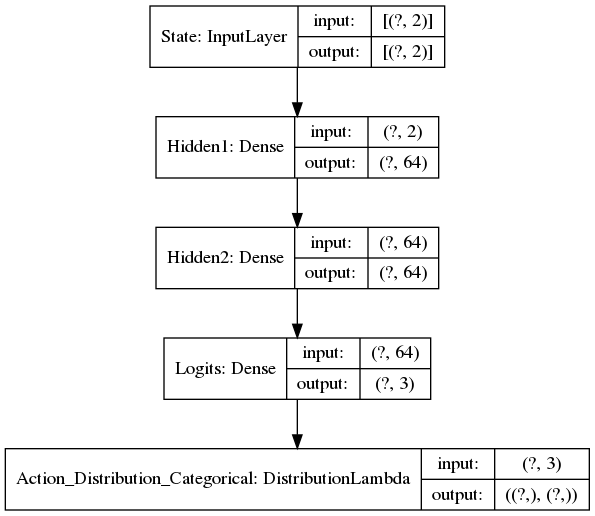

In [10]:
tf.keras.utils.plot_model(policy, show_shapes=True)

## 2. Agente REINFORCE

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left [ \sum_{t=0}^T \nabla_\theta \log \pi_\theta(\mathbf{a}_t|\mathbf{s}_t) \hat{R}(\tau)\right ]
$$

$$
\hat{R}(\tau) = \sum_{t=0}^T r_t
$$


In [11]:
env = gym.make("CartPole-v0")
print(env.spec.reward_threshold)

195.0


In [12]:
class REINFORCE(RLAgent):
    
    def __init__(self, obs_space, action_space, config=None):
        super(REINFORCE, self).__init__(obs_space, action_space, config)
        
        self._build_memory()
        self._build_policy()
        self._build_optimizer()
        
    def _build_memory(self):
        self.memory = OnPolicyReplay()
        
    def _build_policy(self):
        self.policy = build_discrete_policy(self.obs_space, self.action_space, config["hidden_layers"], config["activation"])

    def _build_optimizer(self):
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])

    def act(self, obs):
        return self._act(obs).numpy()
    
    @tf.function
    def _act(self, obs):
        action_dist = self.policy(obs[None,:])
        return action_dist.sample()[0]

    def observe(self, obs, action, reward, next_obs, done):
        self.memory.update(obs, action, reward, next_obs, done)

    def learn(self):
        if self.memory.batch_size < self.config["train_batch_size"]:
            return
        
        batch = self.memory.sample()

        weights = self.policy.trainable_weights

        with tf.GradientTape() as tape:
            loss = self._loss_fn(batch)
            gradients = tape.gradient(loss, weights)

        self.optimizer.apply_gradients(zip(gradients, weights))
      
        return loss

    def _loss_fn(self, batch):
        states, actions, rewards = batch["states"], batch["actions"], batch["rewards"]
        n_episodes = len(states)

        loss = 0.0
        for episode in range(n_episodes):
            action_dist = self.policy(states[episode])
            log_prob = action_dist.log_prob(actions[episode])
            total_reward = np.sum(rewards[episode])
            loss += - tf.reduce_sum(log_prob * total_reward)

        loss /= n_episodes
            
        return loss

In [13]:
config = {
    # policy net
    "hidden_layers": [64, 64],
    "activation": "relu",

    # optimization
    "optimizer": "adam",
    "learning_rate": 3e-3,

    # training
    "train_batch_size": 3000,
}

agent = REINFORCE(env.observation_space, env.action_space, config=config)

## 3. Treinamento do agente

In [14]:
total_timesteps = 500_000
timesteps, total_rewards, avg_total_rewards = run(agent, env, total_timesteps)

In [15]:
plot_returns(timesteps, total_rewards, avg_total_rewards)

## 4. Experimentos 